In [49]:
# Run this cell first - DO NOT MODIFY
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from google.colab import files

# Set random seed for reproducibility
np.random.seed(42)

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Setup complete!")

Setup complete!


In [3]:
uploaded = files.upload()
df =  pd.read_csv('insuranceWithFeatures.csv')

Saving insuranceWithFeatures.csv to insuranceWithFeatures.csv


In [4]:
print(df.head())

   age     sex     bmi  children smoker     region      charges  smoker-age  \
0   19  female  27.900         0    yes  southwest  16884.92400          19   
1   18    male  33.770         1     no  southeast   1725.55230           0   
2   28    male  33.000         3     no  southeast   4449.46200           0   
3   33    male  22.705         0     no  northwest  21984.47061           0   
4   32    male  28.880         0     no  northwest   3866.85520           0   

   Sex-Weight  sexBool  smokerBool  regionSouthWest  regionSouthEast  \
0        27.9        1           1                1                0   
1         0.0        0           0                0                1   
2         0.0        0           0                0                1   
3         0.0        0           0                0                0   
4         0.0        0           0                0                0   

   regionNorthWest  
0                0  
1                0  
2                0  
3       

In [78]:
feature_col = ['age', 'bmi', 'children', 'sexBool', 'smokerBool', 'Sex-Weight', 'smoker-age', 'regionSouthWest', 'regionSouthEast', 'regionNorthWest']

# Prepare data
X_multi = df[feature_col].values
y = df['charges']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[feature_col])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Ridge with small alpha
alphas = [4.4, 4.5, 4.6, 4.7]
ridge = Ridge()
grid = GridSearchCV(ridge, param_grid={'alpha': alphas}, cv=5, scoring='r2')
grid.fit(X_train, y_train)

print("Best alpha:", grid.best_params_)
print("Test R²:", grid.score(X_test, y_test))
# Make predictions
y_pred_train_multi = grid.predict(X_train)
y_pred_test_multi = grid.predict(X_test)
# Calculate metrics
train_mse_multi = mean_squared_error(y_train, y_pred_train_multi)
test_mse_multi = mean_squared_error(y_test, y_pred_test_multi)
train_mae_multi = mean_absolute_error(y_train, y_pred_train_multi)
test_mae_multi = mean_absolute_error(y_test, y_pred_test_multi)
test_r2_multi = r2_score(y_test, y_pred_test_multi)

print(f"\nMultiple Features Model Performance:")
print(f"Training MSE: {train_mse_multi:.2f}")
print(f"Testing MSE: {test_mse_multi:.2f}")
print(f"Training MAE: {train_mae_multi:.2f}")
print(f"Testing MAE: {test_mae_multi:.2f}")
print(f"Testing R²: {test_r2_multi:.3f}")

Best alpha: {'alpha': 4.5}
Test R²: 0.7821344268148174

Multiple Features Model Performance:
Training MSE: 37180307.49
Testing MSE: 33823353.87
Training MAE: 4202.83
Testing MAE: 4198.14
Testing R²: 0.782


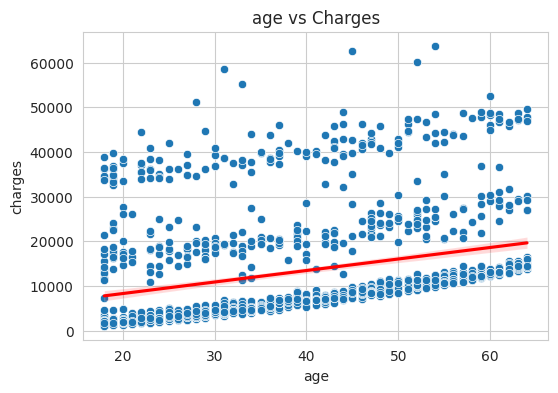

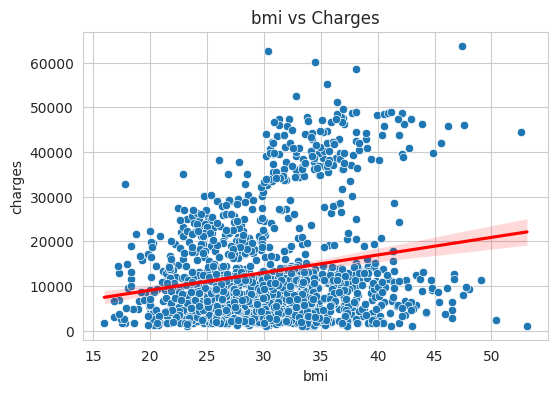

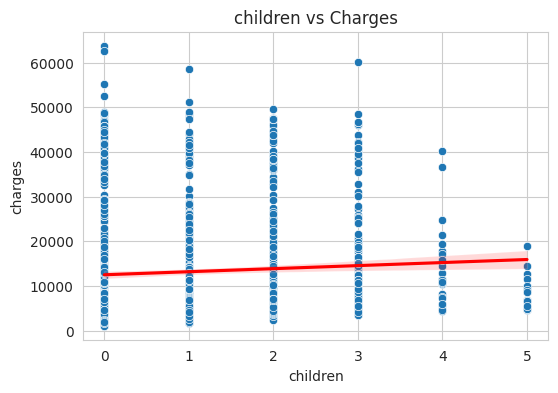

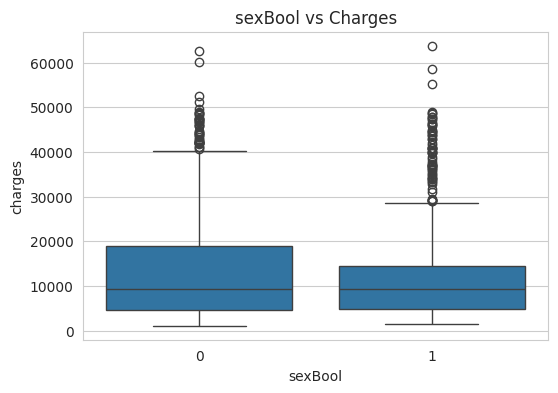

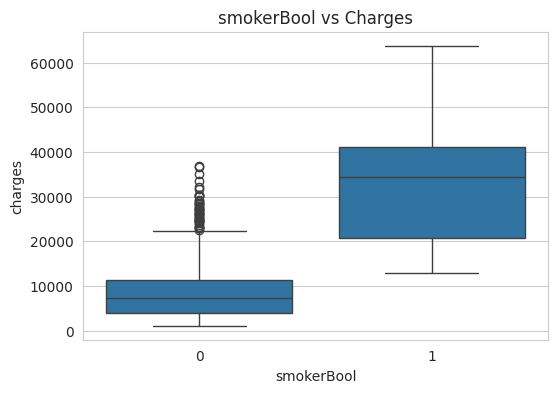

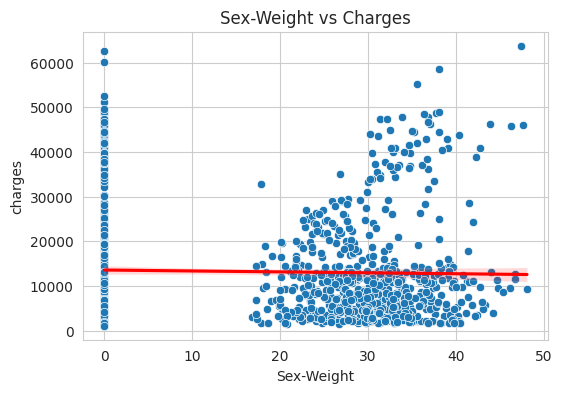

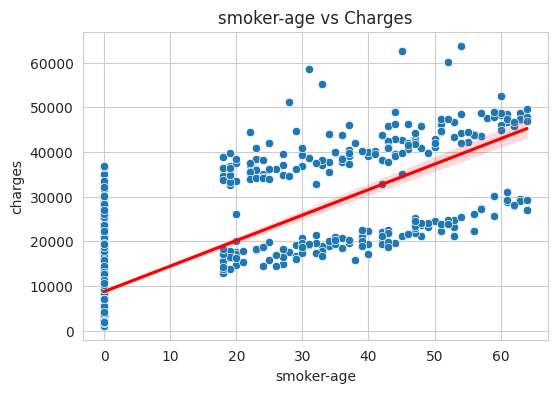

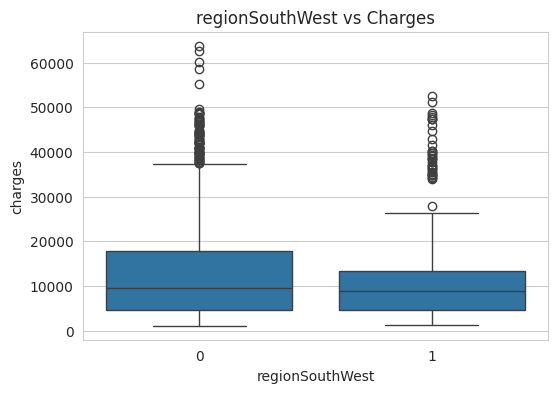

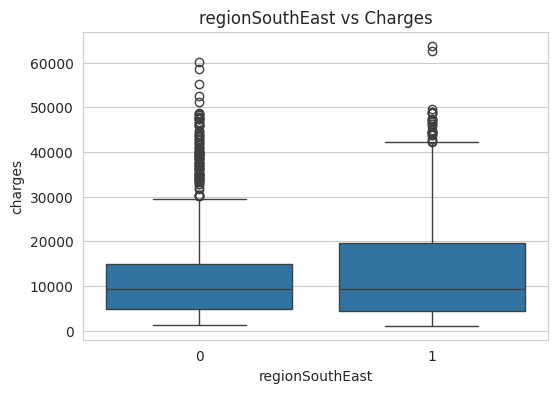

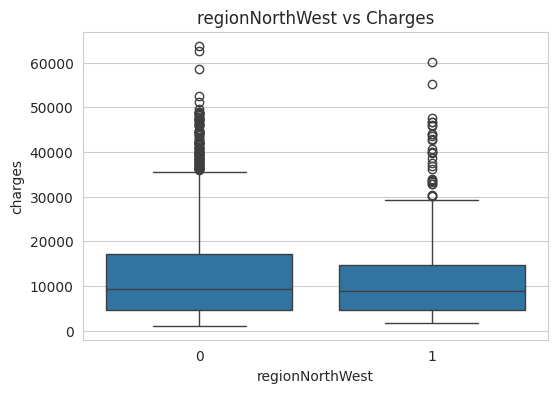

In [79]:
for feature in feature_col:
    plt.figure(figsize=(6,4))
    if df[feature].nunique() <= 5:  # categorical/binary
        sns.boxplot(x=feature, y='charges', data=df)
    else:  # continuous
        sns.scatterplot(x=feature, y='charges', data=df)
        sns.regplot(x=feature, y='charges', data=df, scatter=False, color='red')
    plt.title(f"{feature} vs Charges")
    plt.show()

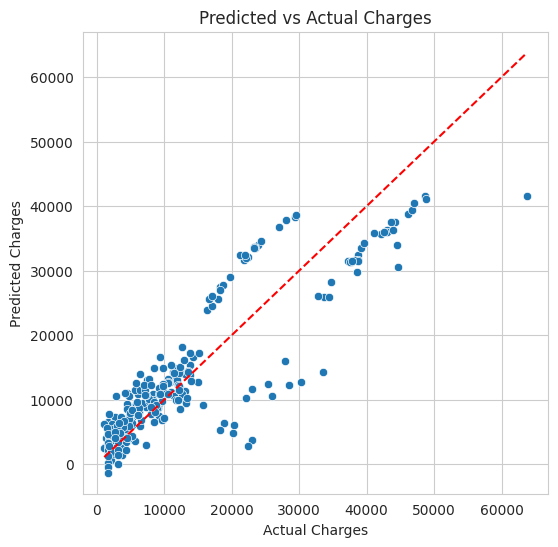

In [80]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_test_multi)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', linestyle='--')
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Predicted vs Actual Charges")
plt.show()

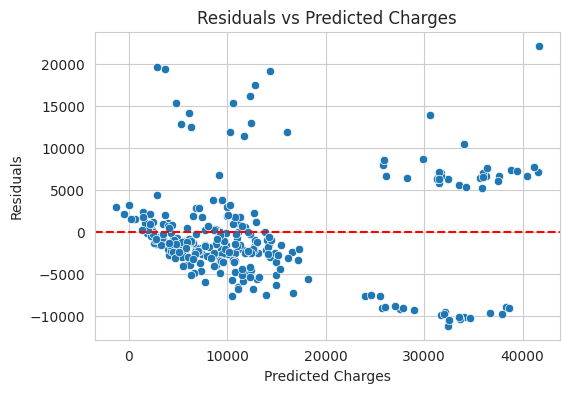

In [81]:
residuals = y_test - y_pred_test_multi
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred_test_multi, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Charges")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Charges")
plt.show()

In [86]:
best_ridge = grid.best_estimator_
beta_scaled = best_ridge.coef_
intercept_scaled = best_ridge.intercept_
means = scaler.mean_
scales = scaler.scale_
beta_original = beta_scaled / scales
intercept_original = intercept_scaled - np.sum((beta_scaled * means) / scales)
for name, coef in zip(feature_col, beta_original):
    print(f"{name}: {coef:.4f}")

print("Intercept:", intercept_original)

age: 240.8218
bmi: 345.9273
children: 408.1068
sexBool: 538.6147
smokerBool: 20764.6504
Sex-Weight: -16.6844
smoker-age: 72.9527
regionSouthWest: -776.1829
regionSouthEast: -689.4101
regionNorthWest: -366.4502
Intercept: -11546.97091361691


The formula for this model is Charge = 240.82*age + 345.93*BMI + 408.10*children# + 538.61*isFemale + 20764.65*isSmoker - 16.68*womenBMI + 72.95*smokerage -776.18*southwest - 689.41*southeast - 366.45*northwest - 11546.97

the womenBMI just means that women get charged less than men as the BMI increases.

The region means that north east is the most expensive region followed by northwest, southeast, then southwest is the cheapest.